In [1]:
# RUNTIME = 'colab'
RUNTIME = 'local'

In [2]:
if RUNTIME == 'colab':
    %%capture
    !pip install polygon-api-client
    !pip install requests
    !pip install pandas
    !pip install tqdm
    !pip install mplfinance
    !pip install tensorflow
    !pip install numpy
    !pip install matplotlib
    !pip install scikit-learn
    !pip install fastparquet

In [3]:
import os
import calendar
from datetime import datetime, timedelta
from functools import partial
import pickle

from polygon import RESTClient
import requests

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Dense,
                                     Dropout,
                                     Activation,
                                     SimpleRNN,
                                     Flatten,
                                     GRU)
from tensorflow.keras.metrics import Precision, Recall, AUC

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import mplfinance as mpf

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

In [4]:
if RUNTIME == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

# 1. Load Data

In [5]:
def get(path, params={}):
    session = requests.Session()
    url = 'https://api.polygon.io' + path
    params['apiKey'] = os.environ['POLYGON_API_KEY']
    resp = session.request('GET', url, params=params)
    resp.raise_for_status()
    return resp.json()

In [6]:
def get_bars(from_date, to_date):
    if isinstance(from_date, datetime):
        from_date = datetime.strftime(from_date, '%Y-%m-%d')
    if isinstance(to_date, datetime):
        to_date = datetime.strftime(to_date, '%Y-%m-%d')
    return get('/v2/aggs/ticker/{}/range/{}/{}/{}/{}'.format('SBUX',
                                                             1,
                                                             'minute',
                                                             from_date,
                                                             to_date))['results']

In [7]:
class TradingDay:
    def __init__(self, date):
        if isinstance(date, str):
            self.start = datetime.strptime(date, '%Y-%m-%d')
        if isinstance(date, datetime):
            self.start = date
        self.end = self.start + timedelta(days=1)
        #self.weekday = calendar.day_name[self.start.weekday()]
        self.bars = pd.DataFrame(columns=['timestamp',
                                          'volume',
                                          'open',
                                          'close',
                                          'high',
                                          'low',
                                          'num_trades'])
        for bar in get_bars(self.start, self.end):
            self.bars = self.bars.append({
                'timestamp': bar['t'],
                'volume': bar['v'],
                'open': bar['o'],
                'close': bar['c'],
                'high': bar['h'],
                'low': bar['l'],
                'num_trades': bar.get('n', 0)
            }, ignore_index=True)
        
class TradingYear:
    def __init__(self, year):
        self.days = [
            TradingDay(
                datetime.strptime(
                    '{}-2019'.format(str(day)), '%j-%Y'
                )
            ) for day in tqdm(range(1,366))
        ]
   
    def get_bars(self):
        return pd.concat([day.bars for day in self.days])

If there is a data file, load it. If not, request data from the Polygon API and save it to a file.

In [8]:
if RUNTIME == 'local':
    DIR = '.data/2019_year_df.parquet.gzip'
elif RUNTIME == 'colab':
    DIR = '/content/drive/My Drive/pbc/2019_year_df.parquet.gzip'

try:
    year_df = pd.read_parquet(DIR)
except FileNotFoundError as e:
    year_df = TradingYear(2019).get_bars()
    year_df['timestamp'] = pd.to_datetime(year_df['timestamp'], unit='ms')
    year_df = year_df.set_index('timestamp')
    year_df.to_parquet(DIR, compression='gzip')

<AxesSubplot:xlabel='timestamp'>

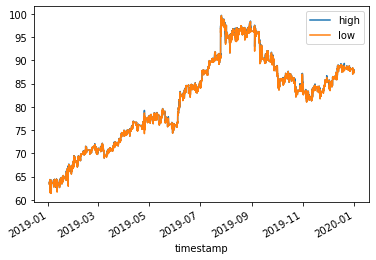

In [9]:
year_df[['high', 'low']].plot()

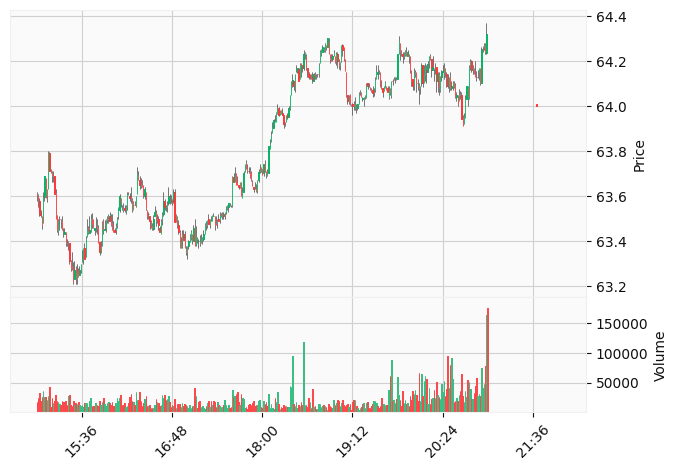

In [10]:
mpf.plot(year_df.loc['2019-01-02 15:00':'2019-01-02 22:00',:], type='candle', volume=True, show_nontrading=True, style='yahoo')


# 2. Feature Engineering

In [11]:
year_df.head()

,volume,open,close,high,low,num_trades
timestamp,,,,,,
2019-01-02 12:17:00,300.0,63.67,63.68,63.68,63.67,4.0
2019-01-02 12:21:00,487.0,63.50,63.53,63.53,63.50,5.0
2019-01-02 12:22:00,1949.0,63.50,63.50,63.50,63.47,8.0
2019-01-02 12:31:00,203.0,63.52,63.52,63.52,63.52,3.0
2019-01-02 12:34:00,238.0,63.55,63.55,63.55,63.55,4.0


Compute the labels we're training for:

In [12]:
FORWARD_WINDOW_SIZE = 5  # looking 5 bars into the future

PCT_WINDOWS = [0.05, 0.1, 0.15, 0.2, 0.25]
LABELS = (['down_{}_pct'.format(pct) for pct in sorted(PCT_WINDOWS, reverse=True)] +
          ['up_{}_pct'.format(pct) for pct in sorted(PCT_WINDOWS)])

In [13]:
tqdm.pandas()  # graphical load bar

def compute_label(formatted_df, pct, direction, row):
    window = formatted_df[formatted_df.index > row.name].iloc[:FORWARD_WINDOW_SIZE]
    if len(window) == FORWARD_WINDOW_SIZE:
        if direction == 'up':
            return int(max(window['high']) >= row['close']*(1+(pct/100)))
        return int(min(window['low']) <= row['close']*(1-(pct/100)))
    return None

/Users/john/.local/share/virtualenvs/pbc-AS_-2Y6Z/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [14]:
TRAILING_WINDOW_SIZE = 60 # looking 60 bars (1 hour) into the past

if RUNTIME == 'local':
    FORMATTED_DF_DIR = '.data/formatted_df_{}min.parquet.gzip'.format(TRAILING_WINDOW_SIZE)
elif RUNTIME == 'colab':
    FORMATTED_DF_DIR = '/content/drive/My Drive/pbc/formatted_df_{}min.parquet.gzip'.format(TRAILING_WINDOW_SIZE)
    
try:
    formatted_df = pd.read_parquet(FORMATTED_DF_DIR)
except FileNotFoundError as e:
    # sanitize
    formatted_df = (year_df
        .sort_index(inplace=False)
        .drop_duplicates()
        # filter out times before 9:30 and after 4:00
        .between_time('13:30','20:00')
        .dropna()
    )
    
    # compute labels
    for pct in PCT_WINDOWS:
        formatted_df['up_{}_pct'.format(pct)] = formatted_df.progress_apply(partial(compute_label, formatted_df, pct, 'up'), axis=1)
        formatted_df['down_{}_pct'.format(pct)] = formatted_df.progress_apply(partial(compute_label, formatted_df, pct, 'down'), axis=1)
    
    # compute features
    formatted_df['open_close_pct_delta'] = (formatted_df['close'] - formatted_df['open'])/formatted_df['open']
    formatted_df['volatility'] = (formatted_df['high'] - formatted_df['low'])/formatted_df['open']
    formatted_df['{}min_volatility_std'.format(TRAILING_WINDOW_SIZE)] = formatted_df['volatility'].rolling(TRAILING_WINDOW_SIZE).std()
    formatted_df['{}min_ocd_std'.format(TRAILING_WINDOW_SIZE)] = formatted_df['open_close_pct_delta'].rolling(TRAILING_WINDOW_SIZE).std()
    scaler = MinMaxScaler()
    formatted_df[['scaled_volume']] = scaler.fit_transform(formatted_df[['volume']])
    
    
    formatted_df = formatted_df.dropna()
    formatted_df.to_parquet(FORMATTED_DF_DIR, compression='gzip')


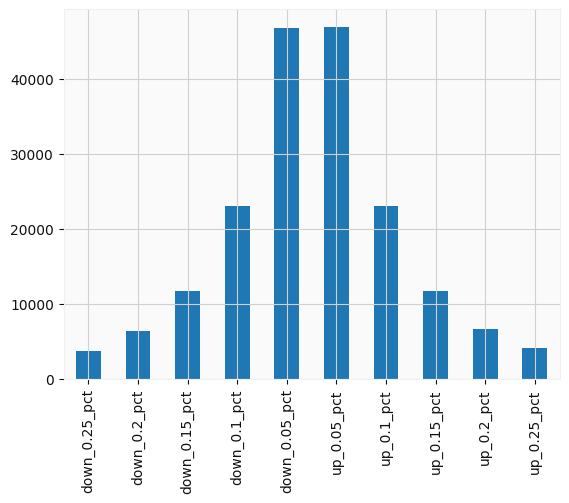

In [15]:
def plot_label_frequency():
    formatted_df[LABELS].sum().plot(kind='bar')
plot_label_frequency()

# 3. Model Utilities

## 3.1. Saving/Loading

In [16]:
def train_model(model, X_train, y_train, X_val, y_val, stack_X=False):
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC(multi_label=True)])

    if stack_X:
        X_train = np.stack(X_train['trailing_col'].values)
        X_val = np.stack(X_val['trailing_col'].values)
    
    return model.fit(X_train,
                     y_train,
                     validation_data=(X_val, y_val),
                     epochs=20,
                     batch_size=20,
                     verbose=0,
                     callbacks=[TqdmCallback()]).history

def save_history(model_dir, history):
    filename = '{}/history.pkl'.format(model_dir)
    pickle.dump(history, open(filename, "wb"))
    print('Wrote history to {}'.format(filename))
    return history

def load_history(model_dir):
    filename = '{}/history.pkl'.format(model_dir)
    print('Loaded history from {}'.format(filename))
    return pickle.load(open(filename, "rb"))

def save_or_load(model, X_train, y_train,
                 X_val, y_val, stack_X=False, **params):
    characteristics = ['{}:{}'.format(key, str(value))
                       for key, value in params.items()]
    model_dir = '.data/{}'.format('_'.join(characteristics))
    print(model_dir)
    
    try:
        return load_model(model_dir), load_history(model_dir)
    except Exception as e:
        print(e)
        history = train_model(model,
                              X_train,
                              y_train,
                              X_val,
                              y_val,
                              stack_X)
        model.save(model_dir)
        return model, save_history(model_dir, history)


## 3.2. Evaluation

In [29]:
def cap_at_one(arr):
    return [elem if elem < 1 else 1
            for elem in arr]

def plot_loss(history):
    fig, axis = plt.subplots()
    color = next(axis._get_lines.prop_cycler)['color']
    
    loss = cap_at_one(history['loss'])
    val_loss = cap_at_one(history['val_loss'])

    epochs = range(1, len(loss) + 1)

    axis.plot(epochs,
              loss,
              color=color,
              linestyle='dotted',
              label='Training loss ({:.3}%)'.format(min(loss)*100))
    axis.plot(epochs,
              val_loss,
              color=color,
              label='Validation loss ({:.3}%)'.format(min(val_loss)*100))
    axis.set_title('Training and validation loss')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('Loss')
    axis.legend()

    plt.show()
    
def find_key_starting_with(dictionary, key_beginning):
    for key in dictionary.keys():
        if key.startswith(key_beginning):
            return dictionary[key]

def plot_recall_precision(history):
    fig, axis = plt.subplots()
    
    color = next(axis._get_lines.prop_cycler)['color']
    recall = cap_at_one(find_key_starting_with(history, 'recall'))
    val_recall = cap_at_one(find_key_starting_with(history, 'val_recall'))
    
    epochs = range(1, len(recall) + 1)
    
    axis.plot(epochs,
             recall,
             color=color,
             linestyle='dotted',
             label='Training recall ({:.3}%)'.format(max(recall)*100))
    axis.plot(epochs,
             val_recall,
             color=color,
             label='Validation recall ({:.3}%)'.format(max(val_recall)*100))
    
    color = next(axis._get_lines.prop_cycler)['color']
    precision = cap_at_one(find_key_starting_with(history, 'precision'))
    val_precision = cap_at_one(find_key_starting_with(history, 'val_precision'))
    
    axis.plot(epochs,
             precision,
             color=color,
             linestyle='dotted',
             label='Training precision ({:.3}%)'.format(max(precision)*100))
    axis.plot(epochs,
             val_precision,
             color=color,
             label='Validation precision ({:.3}%)'.format(max(val_precision)*100))
    
    axis.set_title('Recall and Precision')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('Pct')
    axis.legend()

    plt.show()

def evaluate_model(history):
    plot_loss(history)
    plot_recall_precision(history)

## 3.3. Train/Val/Test Data Splitting

In [18]:
def group_for_rnn(df, periods):
    trailing_values = []
    trailing_col = []
    for idx, row in df[FEATURES].iterrows():
        trailing_values.append(np.asarray(row.values))
        if len(trailing_values) >= TRAILING_WINDOW_SIZE:
            trailing_col.append(np.asarray(trailing_values))
            trailing_values.pop(0)
        else:
            trailing_col.append(None)

    RNN_df = pd.DataFrame({
        **df[LABELS],
        **{'trailing_col': trailing_col}
    }, index=df.index)
    
    return RNN_df.dropna()

def split_train_val_test(df, features):
    X_all = df[features]
    twenty_pct = (len(X_all)//5)
    X_train, X_val, X_test = (X_all[:twenty_pct*3],
                              X_all[twenty_pct*3:twenty_pct*4],
                              X_all[twenty_pct*4:])
    y_all = formatted_df[LABELS]
    y_train, y_val, y_test = (y_all[:twenty_pct*3],
                              y_all[twenty_pct*3:twenty_pct*4],
                              y_all[twenty_pct*4:])
    return X_train, X_val, X_test, y_train, y_val, y_test

# 3. Attempt #1: Simple Neural Net

In [19]:
FEATURES = [
    'open_close_pct_delta',
    'volatility',
    '{}min_volatility_std'.format(TRAILING_WINDOW_SIZE),
    '{}min_ocd_std'.format(TRAILING_WINDOW_SIZE),
    'scaled_volume'
]

(X_train, X_val, X_test,
 y_train, y_val, y_test) = split_train_val_test(formatted_df,
                                                FEATURES)

display(X_train.describe())

,open_close_pct_delta,volatility,60min_volatility_std,60min_ocd_std,scaled_volume
count,56175.000000,56175.000000,56175.000000,56175.000000,56175.000000
mean,-0.000003,0.000580,0.000343,0.000453,0.007428
std,0.000514,0.000520,0.000268,0.000243,0.014311
min,-0.013842,0.000000,0.000085,0.000103,0.000041
25%,-0.000238,0.000285,0.000184,0.000290,0.003163
50%,0.000000,0.000453,0.000248,0.000388,0.004952
75%,0.000223,0.000705,0.000389,0.000548,0.008003
max,0.009662,0.017229,0.002822,0.002808,1.000000


In [20]:
model = Sequential()
model.add(Dense(64, activation='linear', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='linear'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 5,194
Trainable params: 5,194
Non-trainable params: 0
_________________________________________________________________


.data/name:simple_nn
Loaded history from .data/name:simple_nn/history.pkl


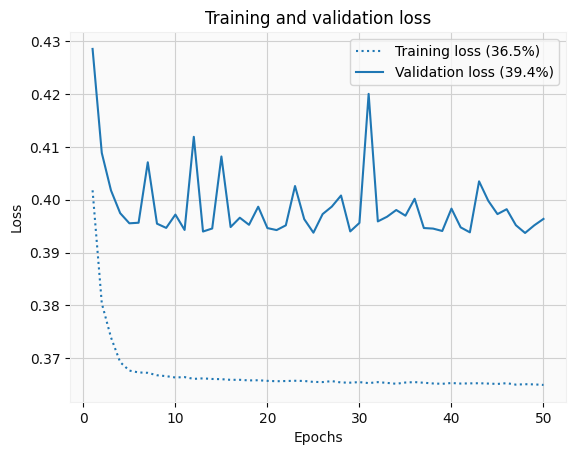

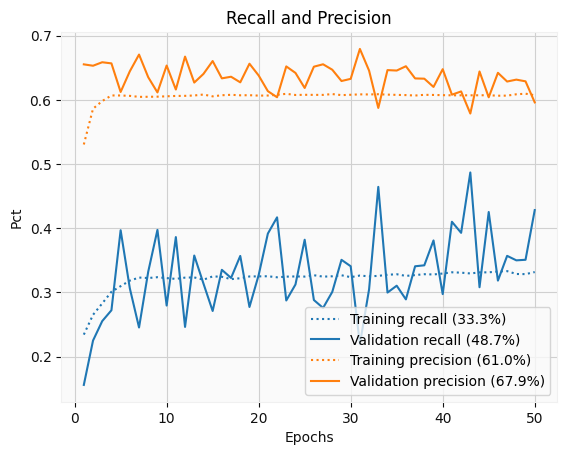

In [21]:
model, history = save_or_load(model,
                              X_train,
                              y_train,
                              X_val,
                              y_val,
                              name='simple_nn')
evaluate_model(history)


# 4. Attempt #2: SimpleRNN

In [22]:
rnn_df = group_for_rnn(formatted_df, TRAILING_WINDOW_SIZE)
display(rnn_df.head())


,down_0.25_pct,down_0.2_pct,down_0.15_pct,down_0.1_pct,down_0.05_pct,up_0.05_pct,up_0.1_pct,up_0.15_pct,up_0.2_pct,up_0.25_pct,trailing_col
timestamp,,,,,,,,,,,
2019-01-02 16:22:00,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[-0.0007881462799495139, 0.000945775535939394..."
2019-01-02 16:23:00,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[0.0, 0.00047326076668234785, 0.0009477786943..."
2019-01-02 16:24:00,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[0.00010569507129688087, 0.000631015351025938..."
2019-01-02 16:25:00,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,"[[-0.0012620287111531519, 0.001419782300047379..."
2019-01-02 16:26:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[-0.00047385879008057395, 0.00082925288264100..."


In [23]:
(X_RNN_train, X_RNN_val, X_RNN_test,
 y_RNN_train, y_RNN_val, y_RNN_test) = split_train_val_test(rnn_df,
                                                            ['trailing_col'])

display(X_RNN_train.head())
display(y_RNN_train.head())

,trailing_col
timestamp,
2019-01-02 16:22:00,"[[-0.0007881462799495139, 0.000945775535939394..."
2019-01-02 16:23:00,"[[0.0, 0.00047326076668234785, 0.0009477786943..."
2019-01-02 16:24:00,"[[0.00010569507129688087, 0.000631015351025938..."
2019-01-02 16:25:00,"[[-0.0012620287111531519, 0.001419782300047379..."
2019-01-02 16:26:00,"[[-0.00047385879008057395, 0.00082925288264100..."


,down_0.25_pct,down_0.2_pct,down_0.15_pct,down_0.1_pct,down_0.05_pct,up_0.05_pct,up_0.1_pct,up_0.15_pct,up_0.2_pct,up_0.25_pct
timestamp,,,,,,,,,,
2019-01-02 15:23:00,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-01-02 15:24:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-01-02 15:25:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-01-02 15:26:00,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2019-01-02 15:27:00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [24]:
n_timesteps = TRAILING_WINDOW_SIZE
n_features = len(X_RNN_train['trailing_col'].iloc[0][0])

display((n_timesteps, n_features))

model = Sequential()
model.add(SimpleRNN(64,
                    activation='linear',
                    input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation='linear'))
model.add(Dense(y_RNN_train.shape[1], activation='sigmoid'))

model.summary()

(60, 5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 64)                4480      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 9,290
Trainable params: 9,290
Non-trainable params: 0
_________________________________________________________________


.data/name:simple_rnn
Loaded history from .data/name:simple_rnn/history.pkl


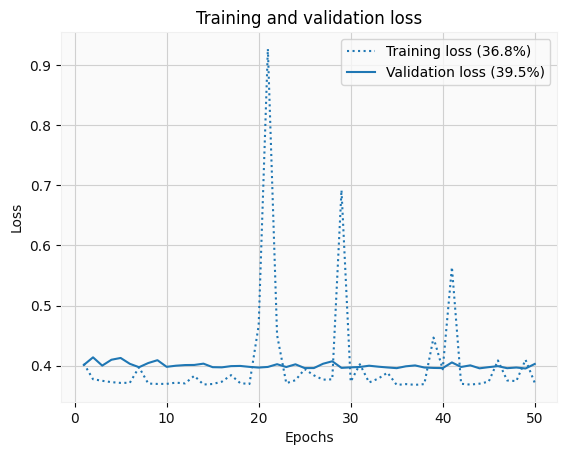

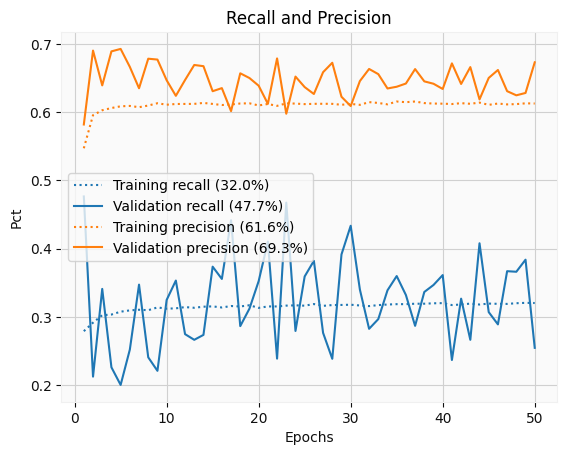

In [25]:
model, history = save_or_load(model,
                              X_RNN_train,
                              y_RNN_train,
                              X_RNN_val,
                              y_RNN_val,
                              stack_X=True,
                              name='simple_rnn')
evaluate_model(history)


# 4. Model #3: GRU

In [26]:
model = Sequential()
model.add(GRU(64,
              activation='linear',
              input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='linear'))
model.add(Dense(y_RNN_train.shape[1], activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                13632     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 18,442
Trainable params: 18,442
Non-trainable params: 0
_________________________________________________________________


.data/name:gru_rnn
Loaded history from .data/name:gru_rnn/history.pkl


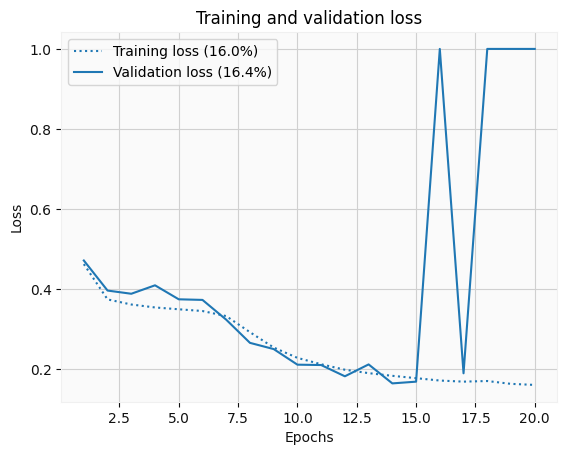

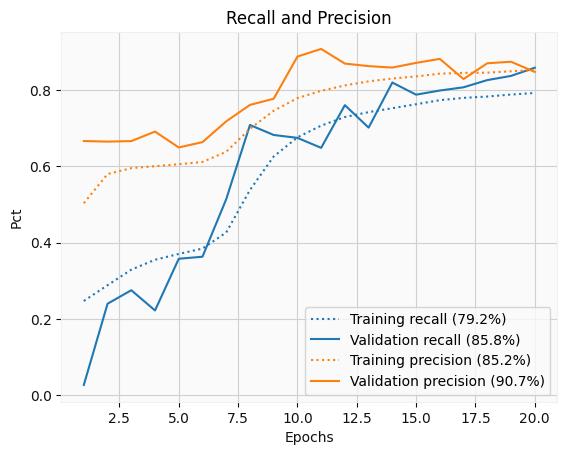

In [30]:
model, history = save_or_load(model,
                              X_RNN_train,
                              y_RNN_train,
                              X_RNN_val,
                              y_RNN_val,
                              stack_X=True,
                              name='gru_rnn')
evaluate_model(history)

In [28]:
history

{'loss': [0.46203893423080444,
  0.37379589676856995,
  0.3610377907752991,
  0.35367465019226074,
  0.34911444783210754,
  0.3447481095790863,
  0.33206290006637573,
  0.2918660640716553,
  0.2535068690776825,
  0.2276432365179062,
  0.21167215704917908,
  0.19799211621284485,
  0.18944290280342102,
  0.18274037539958954,
  0.17691533267498016,
  0.17094632983207703,
  0.1681993305683136,
  0.16975238919258118,
  0.1626398116350174,
  0.16000118851661682],
 'accuracy': [0.30623987317085266,
  0.3102121651172638,
  0.30875149369239807,
  0.3160547912120819,
  0.3179429769515991,
  0.3198845684528351,
  0.3455173671245575,
  0.3946632444858551,
  0.43034255504608154,
  0.4563494324684143,
  0.4729510545730591,
  0.4846363365650177,
  0.4890361428260803,
  0.4953419268131256,
  0.49708759784698486,
  0.49931418895721436,
  0.5007213950157166,
  0.5016120672225952,
  0.5015230178833008,
  0.5039455890655518],
 'precision': [0.5029603838920593,
  0.579398512840271,
  0.5948697328567505,
  